In [55]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import shap

# Ensure necessary directories exist
os.makedirs("results/plots", exist_ok=True)
os.makedirs("results/models", exist_ok=True)

# ------------------------
# Step 1: Data Loading and Preprocessing
# ------------------------

def load_and_preprocess_dataset(file_path, save_path=None):
    """Load and preprocess the dataset by imputing missing values."""
    try:
        data = pd.read_csv(file_path)
        print("\nInitial Dataset Info:")
        print(data.info())
        print("\nChecking for missing values...")
        print(data.isnull().sum())

        # Impute missing values using KNNImputer
        imputer = KNNImputer(n_neighbors=5)
        data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
        print("\nMissing values after imputation:")
        print(data_imputed.isnull().sum())

        # Save preprocessed dataset
        if save_path:
            data_imputed.to_csv(save_path, index=False)
            print(f"\nPreprocessed dataset saved to {save_path}")

        return data_imputed
    except Exception as e:
        print(f"Error loading or preprocessing dataset: {e}")
        return None

In [56]:
# ------------------------
# Step 2: Visualize Dataset
# ------------------------

# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style='white')

# Correlation analysis functions
def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate('r = {:.2f} '.format(r) + p_stars, xy=(0.05, 0.9), xycoords=ax.transAxes)

def annotate_colname(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes, fontweight='bold')

def cor_matrix(df):
    g = sns.PairGrid(df) 
    g.map_upper(sns.regplot, scatter_kws={'s': 10})
    g.map_diag(sns.histplot, kde=True, kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
    g.map_diag(annotate_colname)
    g.map_lower(sns.kdeplot, cmap='Blues_d')
    g.map_lower(corrfunc)
    for ax in g.axes.flatten():
        ax.set_ylabel('')
        ax.set_xlabel('')
    return g

# Enhanced correlation visualization in the main script
def visualize_data(data):
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.savefig(f"results/plots/Heatmap.png")
    plt.show()

    # Plot distributions of features
    data.hist(bins=20, figsize=(12, 10), color='#1e88e5', edgecolor='black')
    plt.suptitle("Feature Distributions")
    plt.tight_layout()
    plt.savefig(f"results/plots/Distributions.png")
    plt.show()

    # Generate the advanced correlation matrix plot
    print("\nGenerating Enhanced Correlation Plot...")
    os.makedirs("results/plots", exist_ok=True)
    selected_columns = data.iloc[:, np.r_[1:5, 11:13]]  # Modify as per your column requirements
    g = cor_matrix(selected_columns)
    plt.savefig("results/plots/feature_correlation2.png")
    plt.show()
    plt.close()
    print("Enhanced Correlation Plot saved at: results/plots/feature_correlation2.png")


In [57]:
# ------------------------
# Step 3: Define Models and Hyperparameters
# ------------------------
models = {
    "Random Forest": (
        RandomForestRegressor(),
        {
            "n_estimators": [10, 50, 100, 200],
            "max_depth": [5, 10, 20, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
    ),
    "Gradient Boosting": (
        GradientBoostingRegressor(),
        {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "subsample": [0.7, 0.8, 0.9, 1.0],
        },
    ),
    "Support Vector Regression": (
        SVR(),
        {
            "C": [0.1, 1, 10, 100],
            "epsilon": [0.01, 0.1, 0.2, 0.5],
            "kernel": ["linear", "rbf"],
        },
    ),
    "Neural Network": (
        MLPRegressor(max_iter=1000),
        {
            "hidden_layer_sizes": [(10,), (20, 20), (40,)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001, 0.01],
            "learning_rate": ["constant", "adaptive"],
        },
    ),
}

In [58]:
# ------------------------
# Step 4: Data Preparation for Modeling
# ------------------------

def prepare_data(data):
    """Prepare data for training and testing."""
    # Define features (X) and targets (y)
    X = data[["eo", "wn", "LL", "PL", "PI"]]
    y_cc = data["Cc"]
    y_si = data["SI"]

    # Scale features and apply power transform to targets
    scaler_X = MinMaxScaler()
    scaler_y = PowerTransformer()

    X_scaled = scaler_X.fit_transform(X)
    y_cc_scaled = scaler_y.fit_transform(y_cc.values.reshape(-1, 1)).flatten()
    y_si_scaled = scaler_y.fit_transform(y_si.values.reshape(-1, 1)).flatten()

    # Train-test split
    X_train, X_test, y_train_cc, y_test_cc = train_test_split(X_scaled, y_cc_scaled, test_size=0.2, random_state=42)
    _, _, y_train_si, y_test_si = train_test_split(X_scaled, y_si_scaled, test_size=0.2, random_state=42)

    return X_train, X_test, y_train_cc, y_test_cc, y_train_si, y_test_si, scaler_X, scaler_y


In [59]:
# ------------------------
# Step 4: Random Search Optimisation
# ------------------------
def random_search(model, params, X_train, y_train):
    random_search = RandomizedSearchCV(
        model,
        params,
        n_iter=80,
        cv=5,
        scoring="r2",
        random_state=42,
        n_jobs=-1,
    )
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_


In [75]:
# ------------------------
# Step 4: Grid Search Optimisation
# ------------------------
def grid_search(model, params, X_train, y_train, random_state=42):
    """
    Perform Grid Search for hyperparameter tuning.
    Ensures reproducibility by setting a random_state where applicable.
    """
    # # Add random_state to the model if it supports it
    # if hasattr(model, "random_state"):
    #     model.set_params(random_state=random_state)

    # Grid Search setup
    grid_search = GridSearchCV(
        model, 
        params, 
        cv=5, 
        scoring="r2", 
        n_jobs=-1, 
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

In [76]:
# ------------------------
# Step 5: Model Training and Evaluation
# ------------------------

def train_evaluate_save(models, X_train, X_test, y_train, y_test, target_variable, scaler_y):
    """Train, evaluate, and save models."""
    results = []

    for name, (model, params) in models.items():
        print(f"\nOptimizing {name} for {target_variable}..."z)
        best_model, best_params = random_search(model, params, X_train, y_train)

        # Save 
        # model
        model_path = f"results/models/{target_variable}_{name}_best.pkl"
        joblib.dump(best_model, model_path)

        # Predict and inverse-transform predictions
        y_pred_train = scaler_y.inverse_transform(best_model.predict(X_train).reshape(-1, 1)).flatten()
        y_pred_test = scaler_y.inverse_transform(best_model.predict(X_test).reshape(-1, 1)).flatten()
        y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

        # Calculate metrics
        r2_train = r2_score(y_train_orig, y_pred_train)
        r2_test = r2_score(y_test_orig, y_pred_test)
        mse_train = mean_squared_error(y_train_orig, y_pred_train)
        mse_test = mean_squared_error(y_test_orig, y_pred_test)

        results.append({
            "model": name,
            "r2_train": r2_train,
            "r2_test": r2_test,
            "mse_train": mse_train,
            "mse_test": mse_test,
            "best_params": best_params,
        })

        # Plot predictions
        plot_predictions(y_train_orig, y_pred_train, y_test_orig, y_pred_test, name, target_variable)

    # Save and compare results
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"results/{target_variable}_metrics.csv", index=False)
    compare_model_performance(results, target_variable)

    print(f"Best model for {target_variable}: {results_df.loc[results_df['r2_test'].idxmax(), 'model']}")
    model_path = f"results/models/{target_variable}_{name}_overallbest.pkl"
    joblib.dump(best_model, model_path)
    
    print(f"Best model for {target_variable}: {results_df.loc[results_df['r2_test'].idxmax(), 'model']}")
    return results_df

# Comparison Performance (already in code, unchanged)
def compare_model_performance(metrics, target_variable):
    """
    Compare model performance using bar charts for R² and MSE scores.
    """
    model_names = [m['model'] for m in metrics]
    r2_train = [m['r2_train'] for m in metrics]
    r2_test = [m['r2_test'] for m in metrics]
    mse_train = [m['mse_train'] for m in metrics]
    mse_test = [m['mse_test'] for m in metrics]

    x = np.arange(len(model_names))
    width = 0.35

    # R² Score Comparison
    plt.figure(figsize=(8, 6))
    plt.bar(x - width / 2, r2_train, width, label='Train R²', color='blue', alpha=0.7)
    plt.bar(x + width / 2, r2_test, width, label='Test R²', color='orange', alpha=0.7)
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.xticks(x, model_names, rotation=45)
    plt.xlabel("Models")
    plt.ylabel("R² Score")
    plt.title(f"R² Score Comparison: {target_variable}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"results/plots/{target_variable}_r2_comparison.png")
    plt.show()
    plt.close()

    # MSE Comparison
    plt.figure(figsize=(8, 6))
    plt.bar(x - width / 2, mse_train, width, label='Train MSE', color='blue', alpha=0.7)
    plt.bar(x + width / 2, mse_test, width, label='Test MSE', color='orange', alpha=0.7)
    plt.xticks(x, model_names, rotation=45)
    plt.xlabel("Models")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Mean Squared Error Comparison: {target_variable}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"results/plots/{target_variable}_mse_comparison.png")
    plt.show()
    plt.close()


def plot_predictions(y_train, y_pred_train, y_test, y_pred_test, model_name, target_variable):
    """Plot predictions for training and testing data."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(y_train, y_pred_train, alpha=0.7, color="blue")
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color="red", lw=2)
    axes[0].set_title(f"{model_name} - Training ({target_variable})")
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")

    axes[1].scatter(y_test, y_pred_test, alpha=0.7, color="blue")
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", lw=2)
    axes[1].set_title(f"{model_name} - Testing ({target_variable})")
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predicted")

    plt.tight_layout()
    plot_path = f"results/plots/{target_variable}_{model_name}_predictions.png"
    plt.savefig(plot_path)
    plt.show()



Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   z       342 non-null    float64
 1   eo      348 non-null    float64
 2   wn      348 non-null    float64
 3   LL      348 non-null    float64
 4   PL      348 non-null    float64
 5   PI      348 non-null    float64
 6   uw      296 non-null    float64
 7   US      335 non-null    float64
 8   ES      340 non-null    float64
 9   PCP     346 non-null    float64
 10  OCR     338 non-null    float64
 11  Cc      348 non-null    float64
 12  SI      261 non-null    float64
dtypes: float64(13)
memory usage: 35.7 KB
None

Checking for missing values...
z       8
eo      2
wn      2
LL      2
PL      2
PI      2
uw     54
US     15
ES     10
PCP     4
OCR    12
Cc      2
SI     89
dtype: int64

Missing values after imputation:
z      0
eo     0
wn     0
LL     0
PL     0
PI     0
uw     

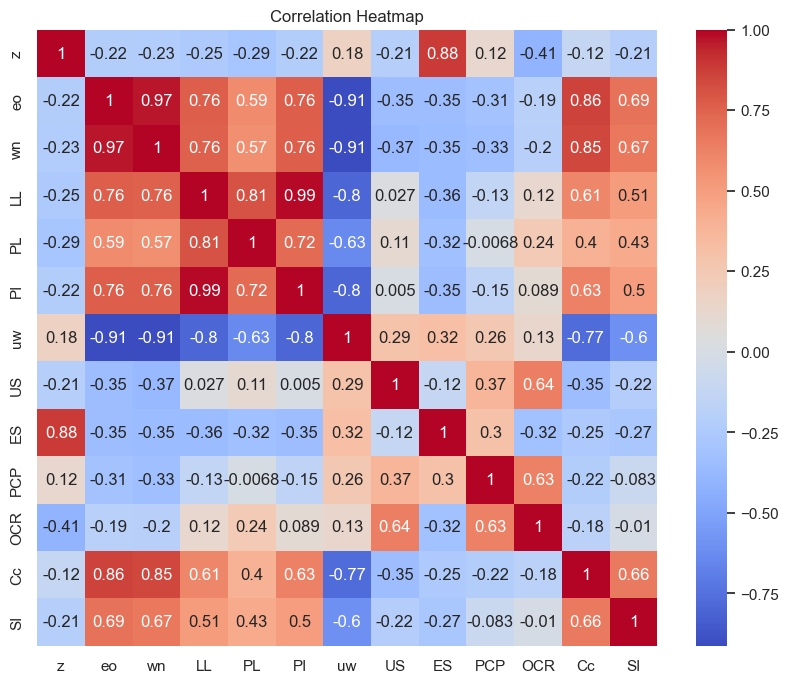

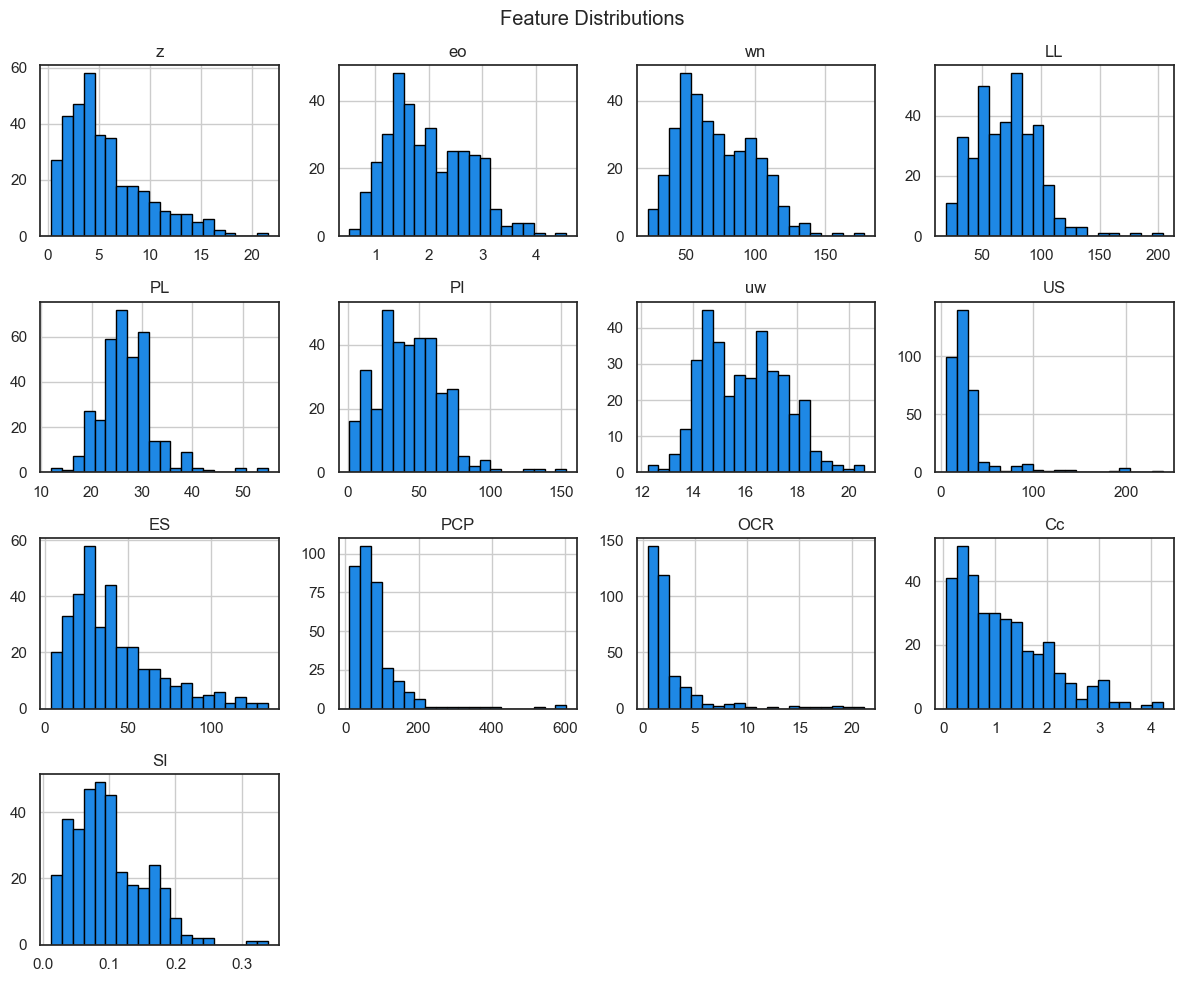


Generating Enhanced Correlation Plot...


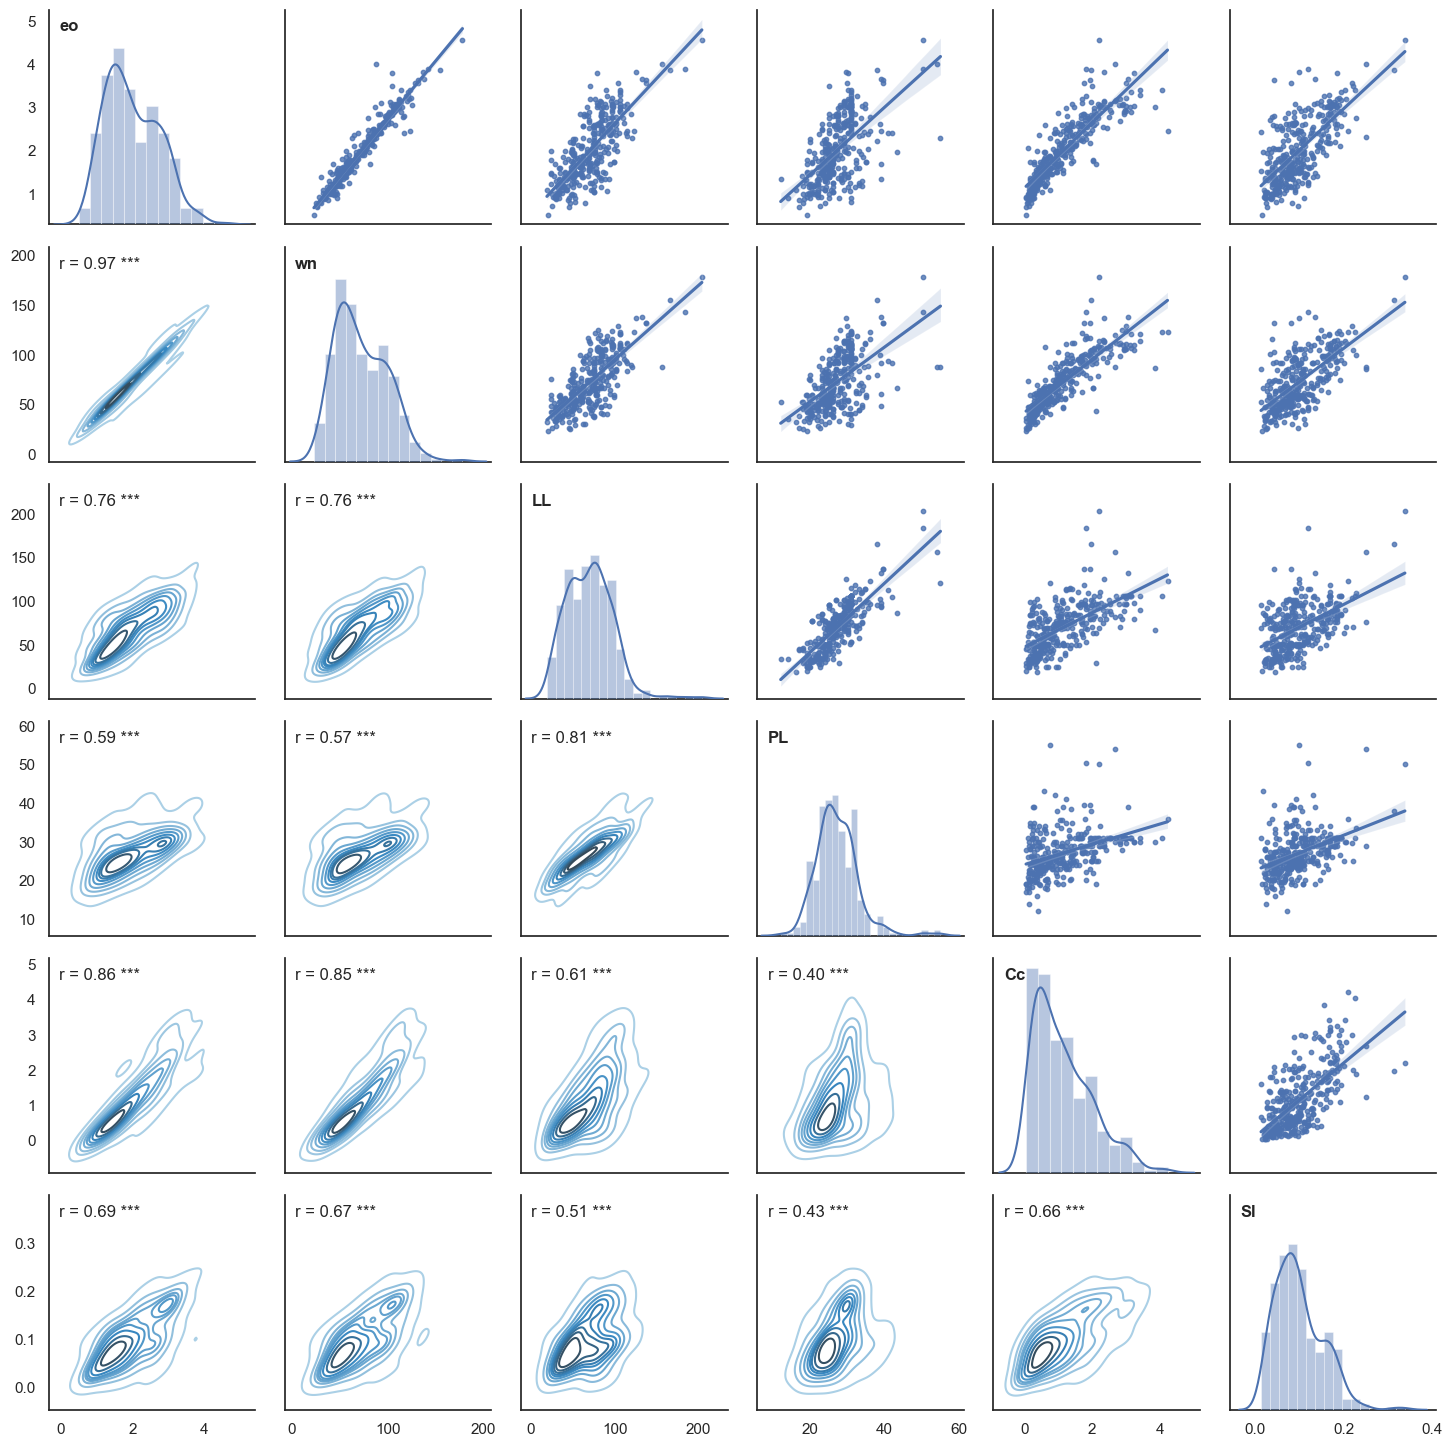

Enhanced Correlation Plot saved at: results/plots/feature_correlation2.png

Training models for Compression Index (Cc):

Optimizing Random Forest for Cc...
Fitting 5 folds for each of 144 candidates, totalling 720 fits


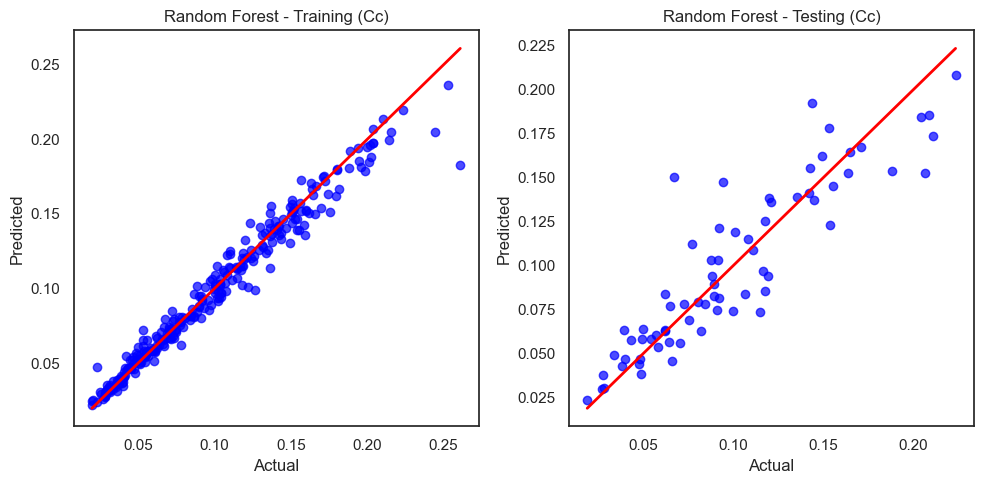


Optimizing Gradient Boosting for Cc...
Fitting 5 folds for each of 144 candidates, totalling 720 fits


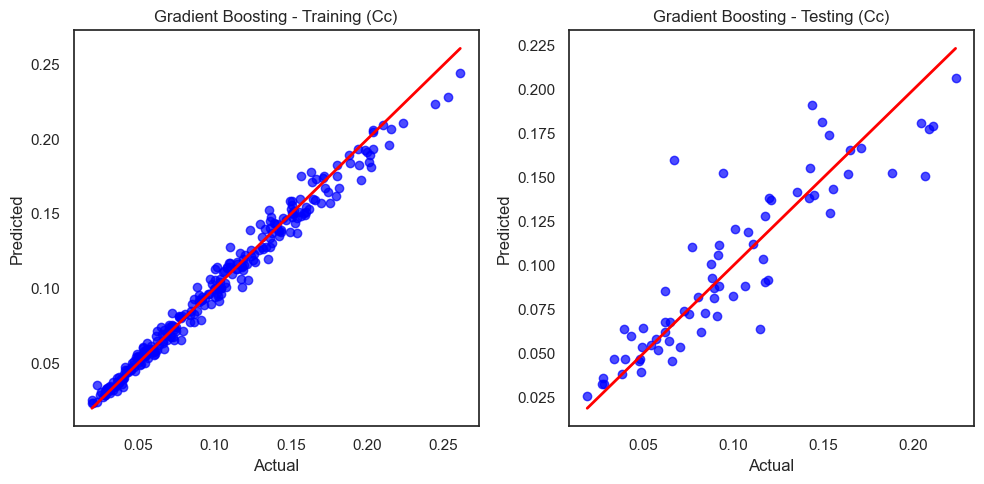


Optimizing Support Vector Regression for Cc...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


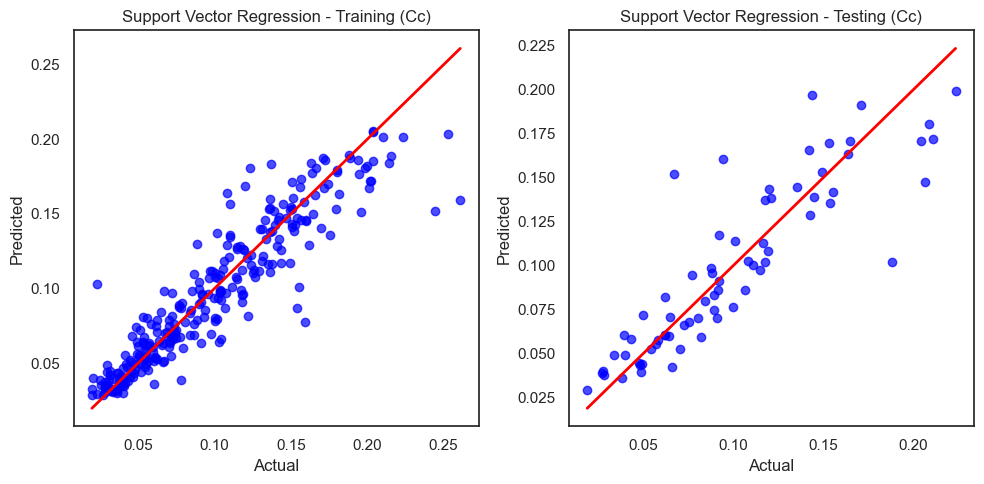


Optimizing Neural Network for Cc...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


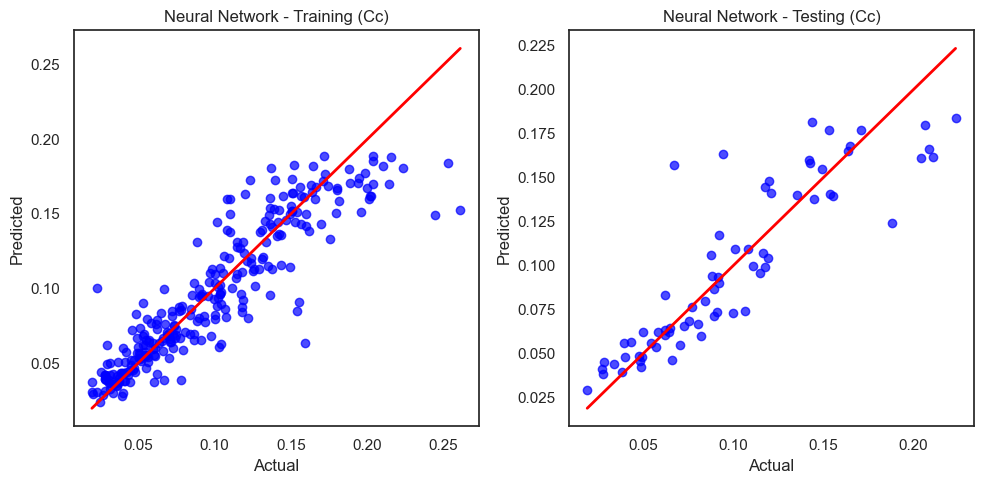

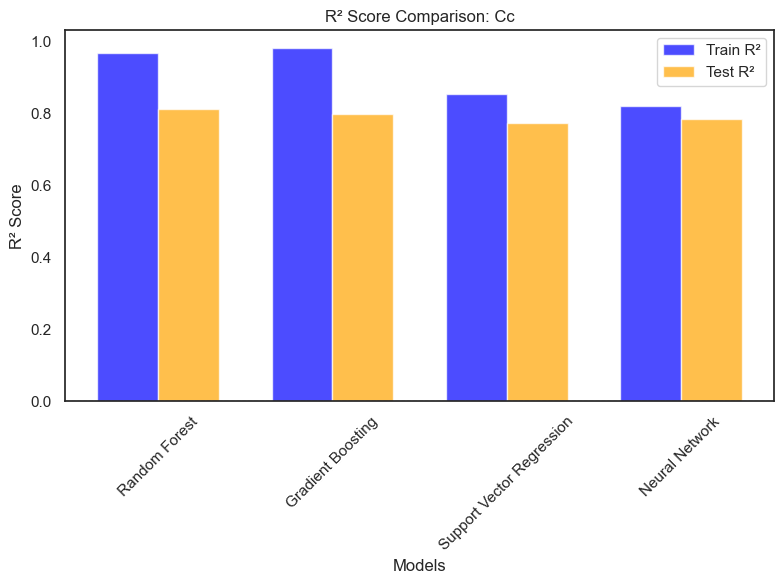

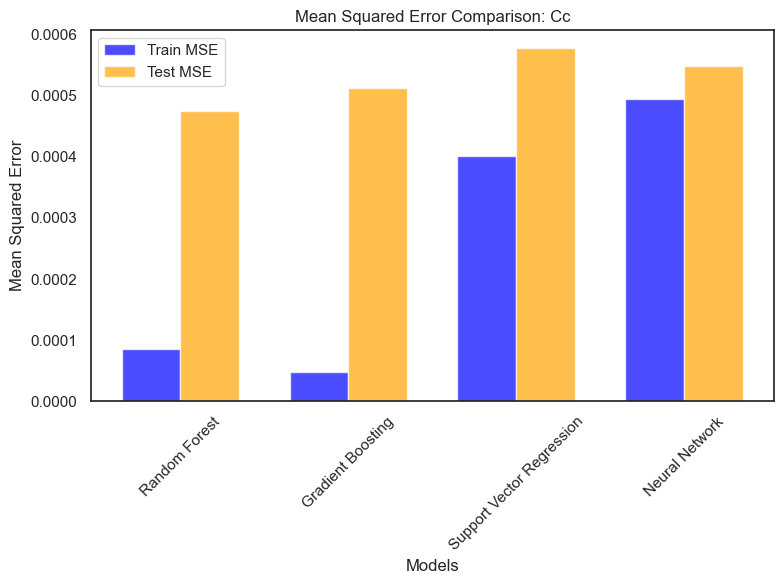

Best model for Cc: Random Forest
Best model for Cc: Random Forest

Training models for Swelling Index (SI):

Optimizing Random Forest for SI...
Fitting 5 folds for each of 144 candidates, totalling 720 fits


e:\01_Personal Gigs\00_Repository\01_Cc\cons_venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


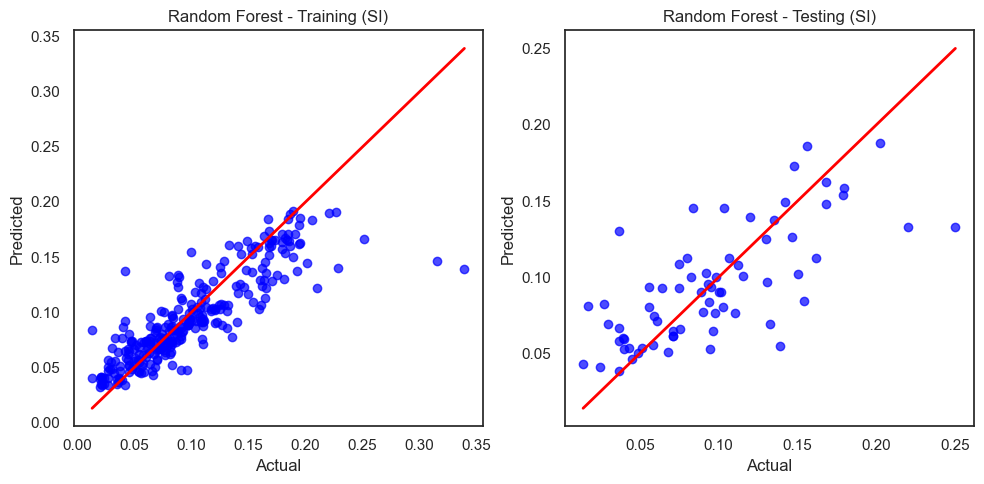


Optimizing Gradient Boosting for SI...
Fitting 5 folds for each of 144 candidates, totalling 720 fits


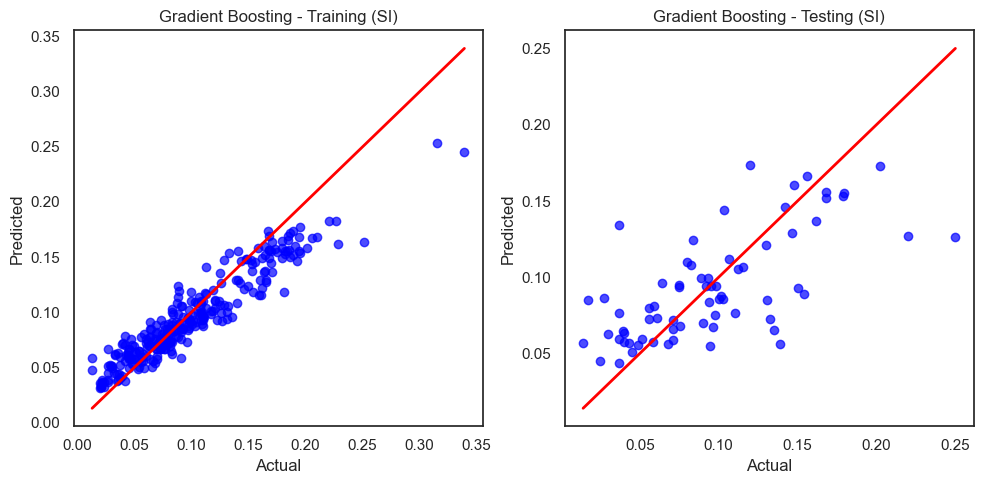


Optimizing Support Vector Regression for SI...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


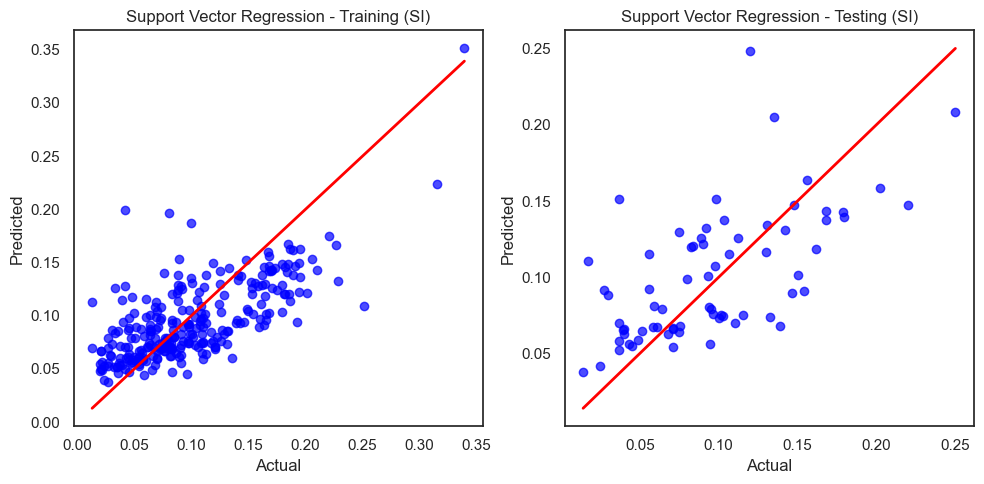


Optimizing Neural Network for SI...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


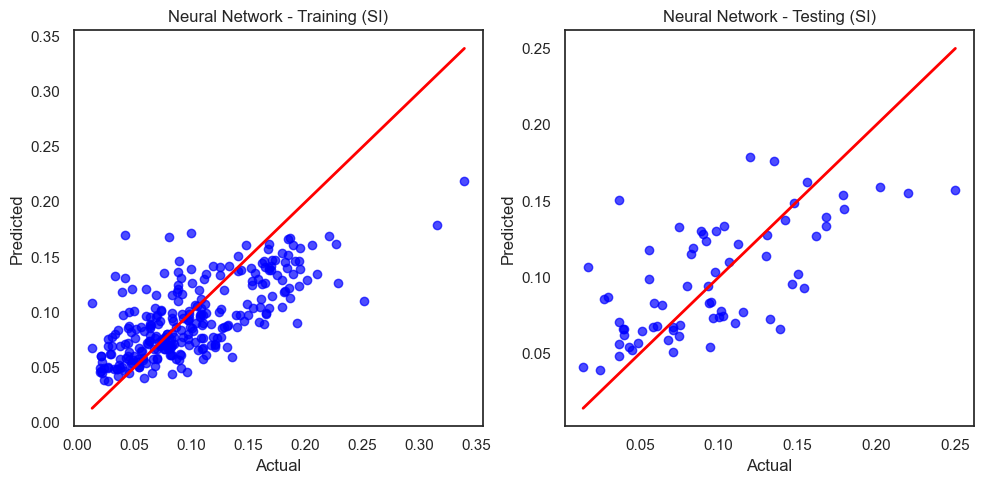

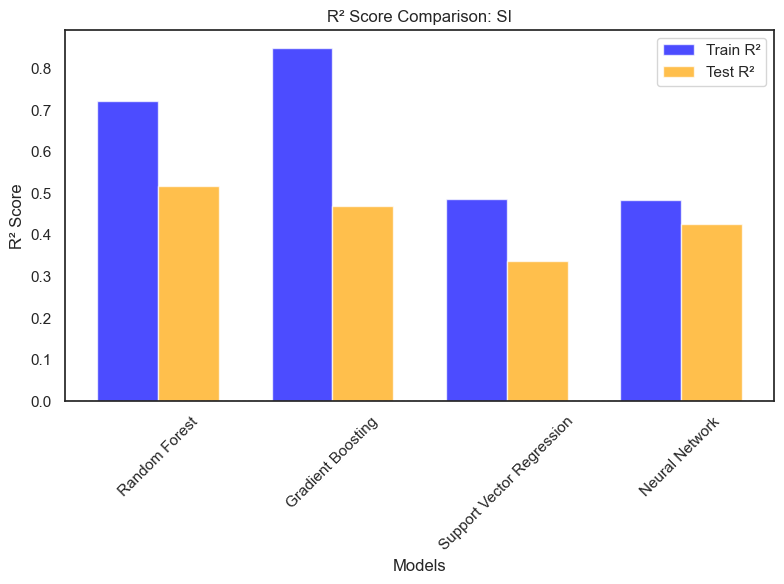

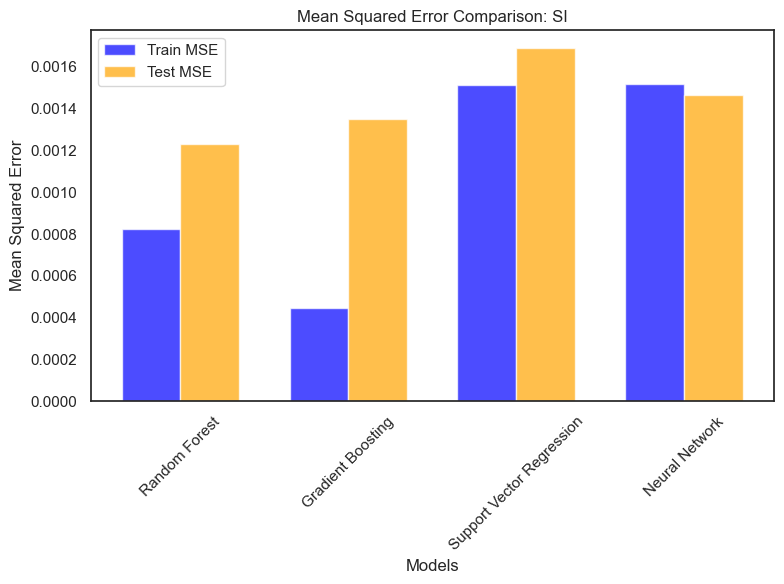

Best model for SI: Random Forest
Best model for SI: Random Forest


In [77]:

# ------------------------
# Main Execution
# ------------------------

if __name__ == "__main__":
    file_path = "Cc_Input_02.csv"
    save_path = "Cc_Input_02_preprocessed.csv"

    # Load and preprocess the dataset
    data = load_and_preprocess_dataset(file_path, save_path)

    if data is not None:
        # Visualize the data
        visualize_data(data)

        # Prepare data for modeling
        X_train, X_test, y_train_cc, y_test_cc, y_train_si, y_test_si, scaler_X, scaler_y = prepare_data(data)

        # ------------------------
        # Step 3: Define Models and Hyperparameters
        # ------------------------
        models = {
            "Random Forest": (
                RandomForestRegressor(),
                {
                    "n_estimators": [10, 50, 100, 200],
                    "max_depth": [5, 10, 20, None],
                    "min_samples_split": [2, 5, 10],
                    "min_samples_leaf": [1, 2, 4],
                },
            ),
            "Gradient Boosting": (
                GradientBoostingRegressor(),
                {
                    "n_estimators": [50, 100, 200],
                    "learning_rate": [0.01, 0.05, 0.1, 0.2],
                    "max_depth": [3, 5, 7],
                    "subsample": [0.7, 0.8, 0.9, 1.0],
                },
            ),
            "Support Vector Regression": (
                SVR(),
                {
                    "C": [0.1, 1, 10, 100],
                    "epsilon": [0.01, 0.1, 0.2, 0.5],
                    "kernel": ["linear", "rbf"],
                },
            ),
            "Neural Network": (
                MLPRegressor(max_iter=1000),
                {
                    "hidden_layer_sizes": [(10,), (20, 20), (40,)],
                    "activation": ["relu", "tanh"],
                    "alpha": [0.0001, 0.001, 0.01],
                    "learning_rate": ["constant", "adaptive"],
                },
            ),
        }

        # Train and evaluate models
        print("\nTraining models for Compression Index (Cc):")
        train_evaluate_save(models, X_train, X_test, y_train_cc, y_test_cc, "Cc", scaler_y)

        print("\nTraining models for Swelling Index (SI):")
        train_evaluate_save(models, X_train, X_test, y_train_si, y_test_si, "SI", scaler_y)
